In [ ]:
# %pip install seaborn

In [1]:
%run "E:/DataEngineering/Ipl-Analytics/projects/ipynb/00_Set_Environmnet.ipynb"

[INFO] Initializing Spark session...
[INFO] Spark session initialized successfully.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum, when,regexp_replace,lower,current_date
from pyspark.sql.window import Window

In [2]:
# -----------------------------------------------------------
# Step 2: Read All Cleaned CSV Tables into a Dictionary
# -----------------------------------------------------------
base_path = "file:///E:/DataEngineering/Ipl-Analytics/cleaned-data/"
table_names = ["Ball_By_Ball", "Match", "Player", "PlayerMatch", "Team"]
dataframes = {}

print("------------------------------------------------------------")
print("[INFO] Reading cleaned data tables...")

for table in table_names:
    full_path = base_path + table
    try:
        df = spark.read.option("header", True).option("inferSchema", True).load(full_path)
        df.createOrReplaceTempView(table)
        dataframes[table] = df
        print(f"[SUCCESS] Table loaded and view created: {table}")
    except Exception as e:
        print(f"[ERROR] Failed to load table {table}: {e}")

------------------------------------------------------------
[INFO] Reading cleaned data tables...
[SUCCESS] Table loaded and view created: Ball_By_Ball
[SUCCESS] Table loaded and view created: Match
[SUCCESS] Table loaded and view created: Player
[SUCCESS] Table loaded and view created: PlayerMatch
[SUCCESS] Table loaded and view created: Team


In [3]:
df_match = dataframes["Match"]
df_match_pd = df_match.toPandas()

In [4]:
print(df_match_pd.columns)

Index(['match_sk', 'match_id', 'team1', 'team2', 'match_date', 'season_year',
       'venue_name', 'city_name', 'country_name', 'toss_winner',
       'match_winner', 'toss_name', 'win_type', 'outcome_type', 'manofmach',
       'win_margin', 'country_id', 'match_date_cleaned'],
      dtype='object')


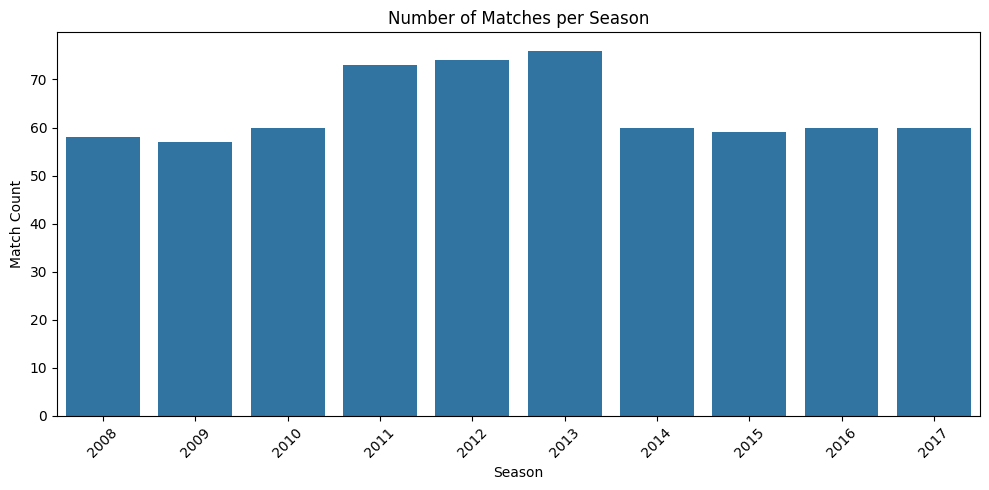

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df_match_pd, x="season_year", order=sorted(df_match_pd["season_year"].unique()))
plt.title("Number of Matches per Season")
plt.xlabel("Season")
plt.ylabel("Match Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



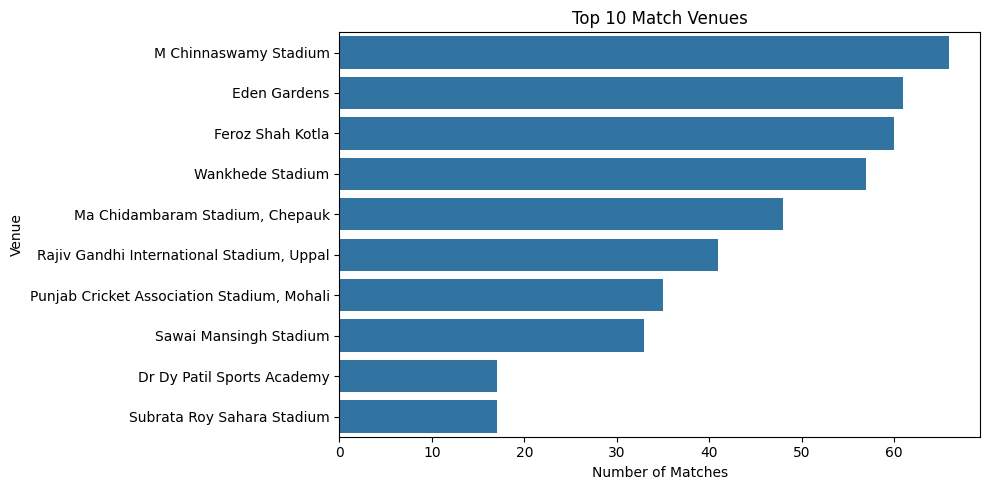

In [6]:
top_venues = df_match_pd['venue_name'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_venues.values, y=top_venues.index)
plt.title("Top 10 Match Venues")
plt.xlabel("Number of Matches")
plt.ylabel("Venue")
plt.tight_layout()
plt.show()


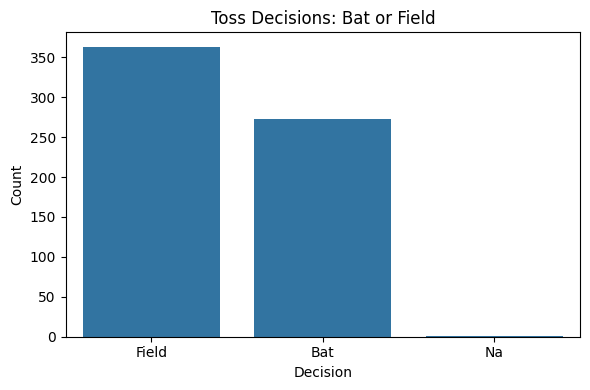

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_match_pd, x="toss_name")
plt.title("Toss Decisions: Bat or Field")
plt.xlabel("Decision")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


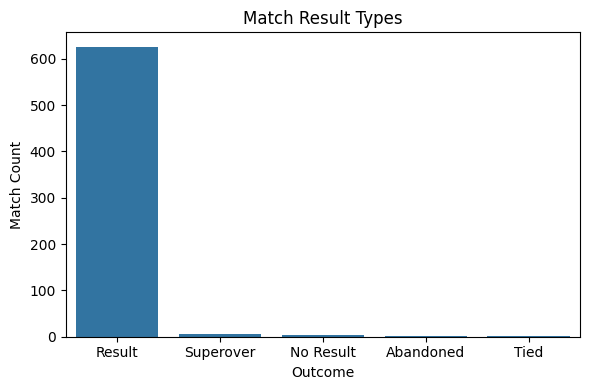

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_match_pd, x="outcome_type")
plt.title("Match Result Types")
plt.xlabel("Outcome")
plt.ylabel("Match Count")
plt.tight_layout()
plt.show()


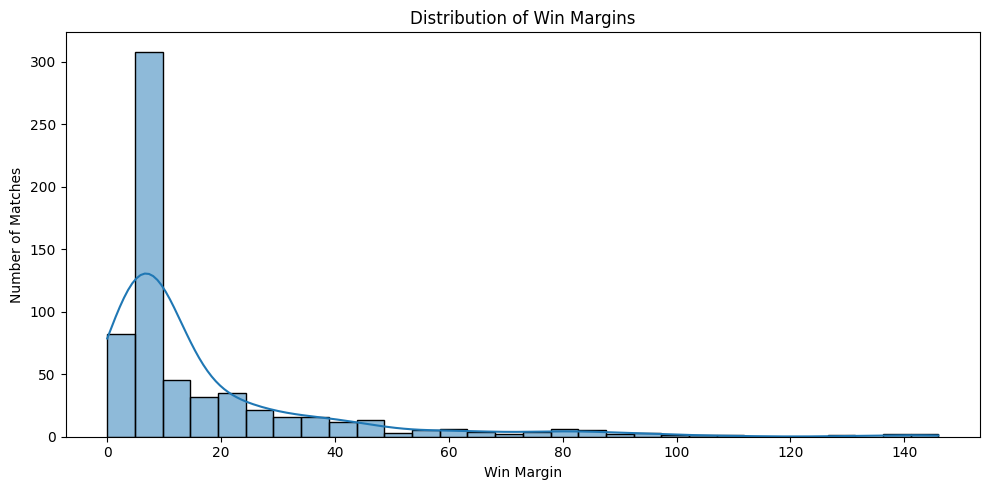

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_match_pd, x="win_margin", bins=30, kde=True)
plt.title("Distribution of Win Margins")
plt.xlabel("Win Margin")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()


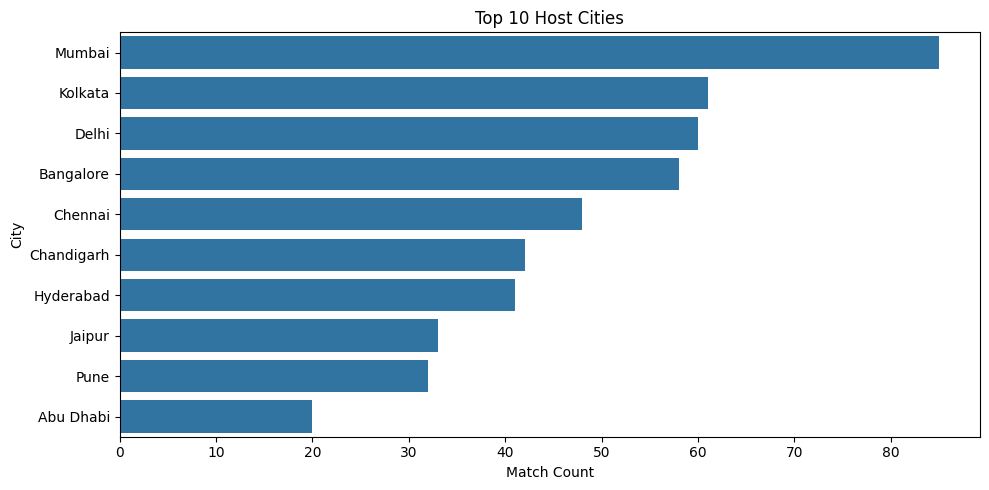

In [10]:
top_cities = df_match_pd['city_name'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_cities.values, y=top_cities.index)
plt.title("Top 10 Host Cities")
plt.xlabel("Match Count")
plt.ylabel("City")
plt.tight_layout()
plt.show()


In [11]:
df_Ball_By_Ball=dataframes['Ball_By_Ball']
df_Ball_By_Ball_pd=df_Ball_By_Ball.toPandas()

In [12]:
df_Ball_By_Ball_pd.columns

Index(['match_id', 'over_id', 'ball_id', 'innings_no', 'team_batting',
       'team_bowling', 'striker_batting_position', 'extra_type', 'runs_scored',
       'extra_runs', 'wides', 'legbyes', 'byes', 'noballs', 'penalty',
       'bowler_extras', 'out_type', 'caught', 'bowled', 'run_out', 'lbw',
       'retired_hurt', 'stumped', 'caught_and_bowled', 'hit_wicket',
       'obstructingfeild', 'bowler_wicket', 'match_date', 'season', 'striker',
       'non_striker', 'bowler', 'player_out', 'fielders', 'striker_match_sk',
       'strikersk', 'nonstriker_match_sk', 'nonstriker_sk', 'fielder_match_sk',
       'fielder_sk', 'bowler_match_sk', 'bowler_sk', 'playerout_match_sk',
       'battingteam_sk', 'bowlingteam_sk', 'keeper_catch', 'player_out_sk',
       'matchdatesk', 'match_date_cleaned'],
      dtype='object')

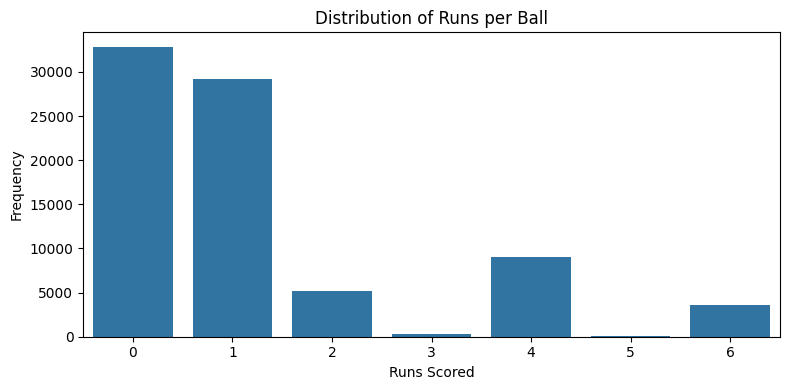

In [13]:
df_ball = dataframes["Ball_By_Ball"].toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=df_ball, x="runs_scored")
plt.title("Distribution of Runs per Ball")
plt.xlabel("Runs Scored")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


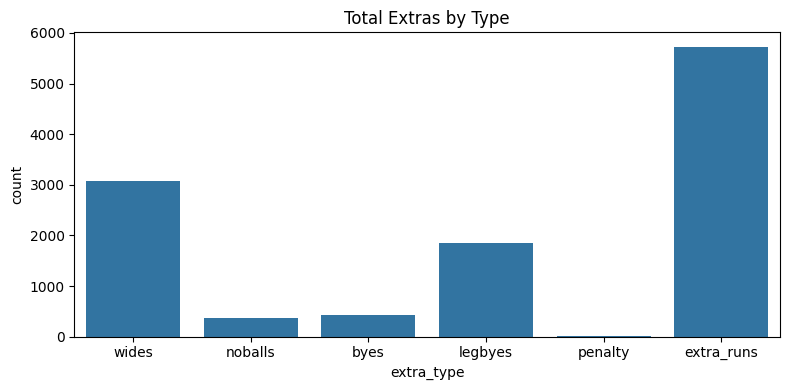

In [14]:
extras_cols = ["wides", "noballs", "byes", "legbyes", "penalty", "extra_runs"]
df_extras = df_ball[extras_cols].sum().reset_index()
df_extras.columns = ["extra_type", "count"]

plt.figure(figsize=(8, 4))
sns.barplot(data=df_extras, x="extra_type", y="count")
plt.title("Total Extras by Type")
plt.tight_layout()
plt.show()


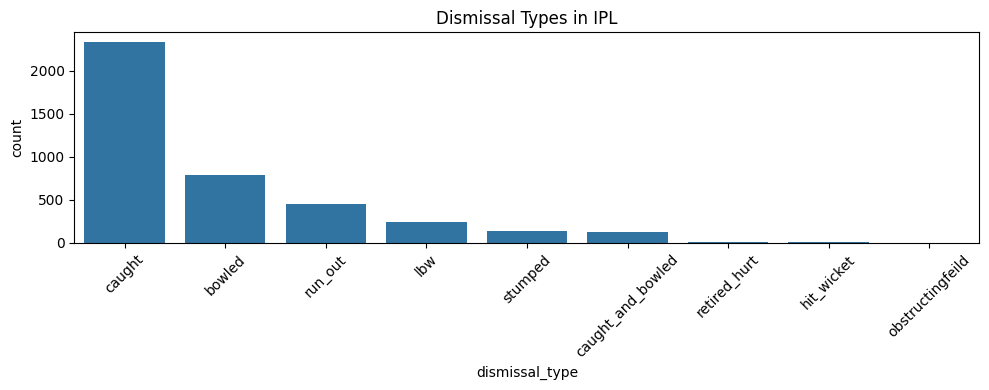

In [15]:
dismissal_cols = ["caught", "bowled", "run_out", "lbw", "retired_hurt", "stumped", "caught_and_bowled", "hit_wicket", "obstructingfeild"]

dismissal_counts = df_ball[dismissal_cols].sum().sort_values(ascending=False)
dismissal_counts = dismissal_counts.reset_index()
dismissal_counts.columns = ["dismissal_type", "count"]

plt.figure(figsize=(10, 4))
sns.barplot(data=dismissal_counts, x="dismissal_type", y="count")
plt.title("Dismissal Types in IPL")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


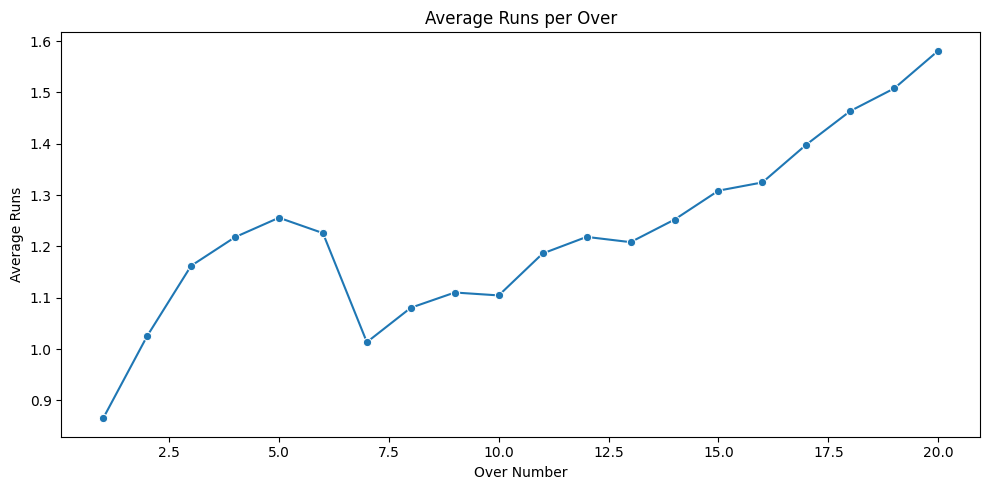

In [16]:
df_runs_per_over = df_ball.groupby("over_id")["runs_scored"].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_runs_per_over, x="over_id", y="runs_scored", marker="o")
plt.title("Average Runs per Over")
plt.xlabel("Over Number")
plt.ylabel("Average Runs")
plt.tight_layout()
plt.show()


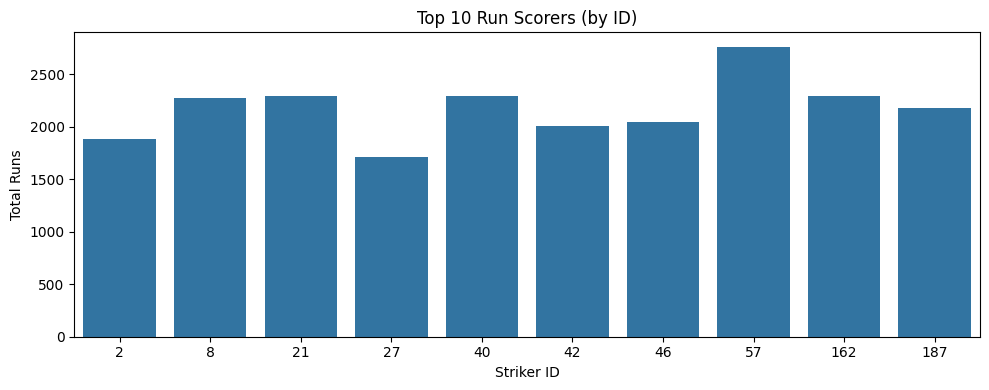

In [17]:
top_batters = df_ball.groupby("striker")["runs_scored"].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(data=top_batters, x="striker", y="runs_scored")
plt.title("Top 10 Run Scorers (by ID)")
plt.xlabel("Striker ID")
plt.ylabel("Total Runs")
plt.tight_layout()
plt.show()


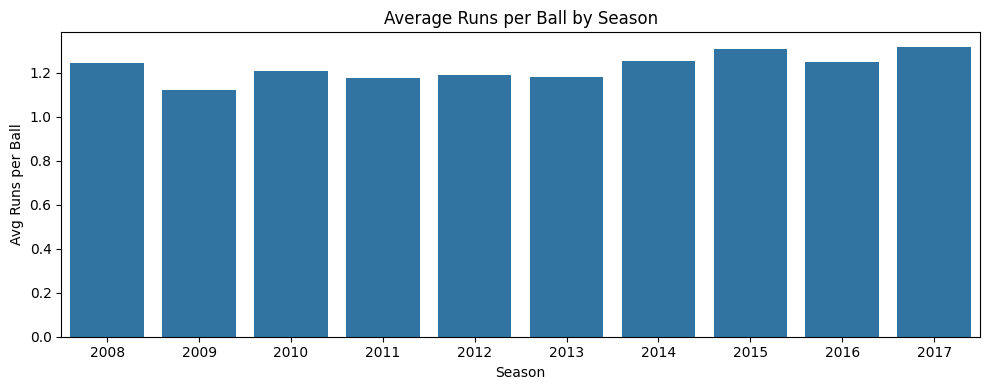

In [18]:
df_bbb = dataframes["Ball_By_Ball"]
df_match = dataframes["Match"]

# Join on match_id
df_joined = df_bbb.join(df_match, df_bbb["match_id"] == df_match["match_id"], "left")

# Convert to Pandas for plotting
df_joined_pd = df_joined.select("season_year", "runs_scored").toPandas()

# Plot average runs per season
plt.figure(figsize=(10, 4))
sns.barplot(data=df_joined_pd.groupby("season_year").mean().reset_index(), x="season_year", y="runs_scored")
plt.title("Average Runs per Ball by Season")
plt.xlabel("Season")
plt.ylabel("Avg Runs per Ball")
plt.tight_layout()
plt.show()


In [19]:
df_match_pd = dataframes["Match"].toPandas()


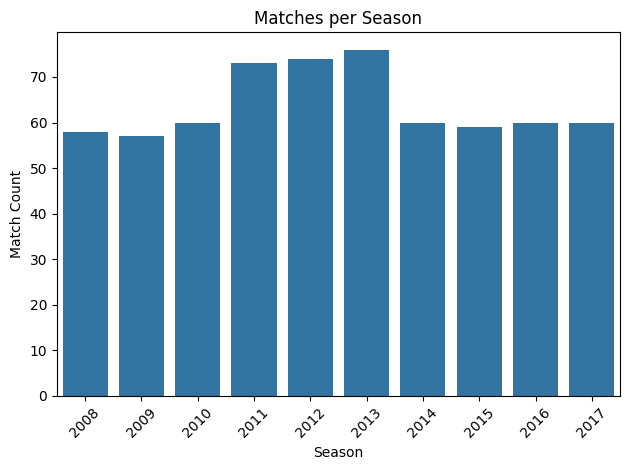

In [20]:
sns.countplot(data=df_match_pd, x="season_year", order=sorted(df_match_pd["season_year"].unique()))
plt.title("Matches per Season")
plt.xlabel("Season")
plt.ylabel("Match Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


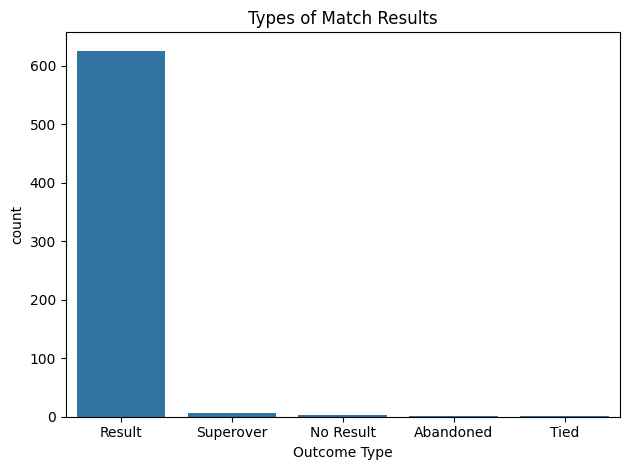

In [21]:
sns.countplot(data=df_match_pd, x="outcome_type")
plt.title("Types of Match Results")
plt.xlabel("Outcome Type")
plt.tight_layout()
plt.show()


In [22]:
df_player_pd = dataframes["Player"].toPandas()


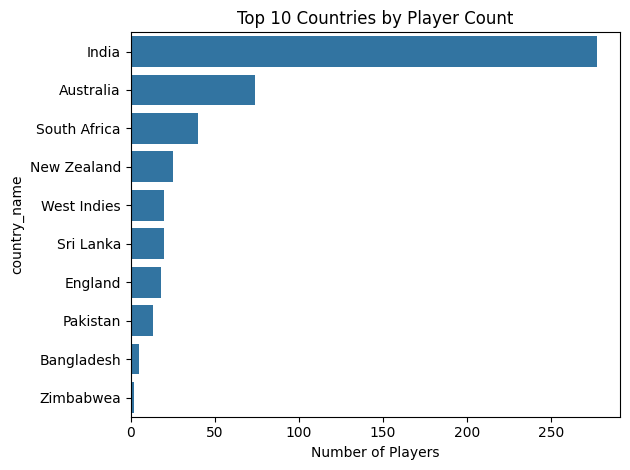

In [23]:
top_countries = df_player_pd['country_name'].value_counts().head(10)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top 10 Countries by Player Count")
plt.xlabel("Number of Players")
plt.tight_layout()
plt.show()


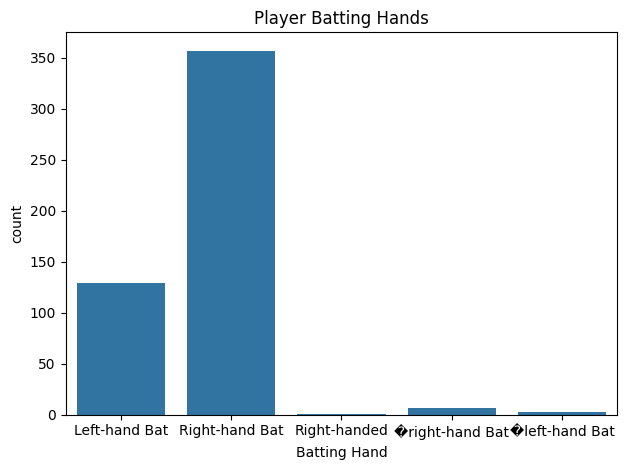

In [24]:
sns.countplot(data=df_player_pd, x="batting_hand")
plt.title("Player Batting Hands")
plt.xlabel("Batting Hand")
plt.tight_layout()
plt.show()


C:\Users\surve\AppData\Local\Temp\ipykernel_35504\2906924816.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_player_pd['bowling_skill'].fillna("Unknown", inplace=True)


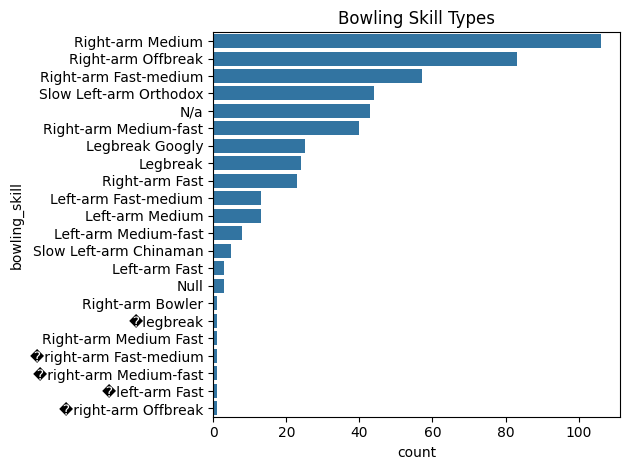

In [25]:
df_player_pd['bowling_skill'].fillna("Unknown", inplace=True)
sns.countplot(data=df_player_pd, y="bowling_skill", order=df_player_pd['bowling_skill'].value_counts().index)
plt.title("Bowling Skill Types")
plt.tight_layout()
plt.show()


In [26]:
df_playermatch_pd = dataframes["PlayerMatch"].toPandas()


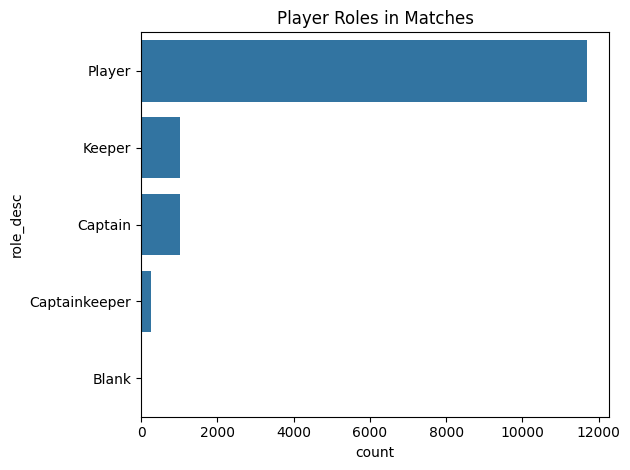

In [27]:
sns.countplot(data=df_playermatch_pd, y="role_desc", order=df_playermatch_pd["role_desc"].value_counts().index)
plt.title("Player Roles in Matches")
plt.tight_layout()
plt.show()


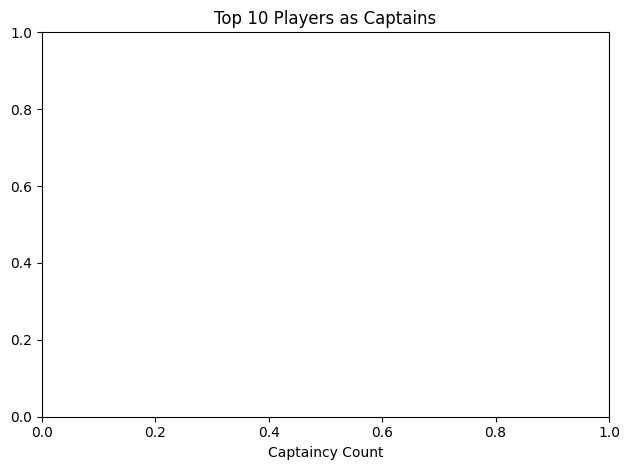

In [28]:
captain_counts = df_playermatch_pd[df_playermatch_pd['player_captain'] == "Y"]['player_name'].value_counts().head(10)
sns.barplot(y=captain_counts.index, x=captain_counts.values)
plt.title("Top 10 Players as Captains")
plt.xlabel("Captaincy Count")
plt.tight_layout()
plt.show()


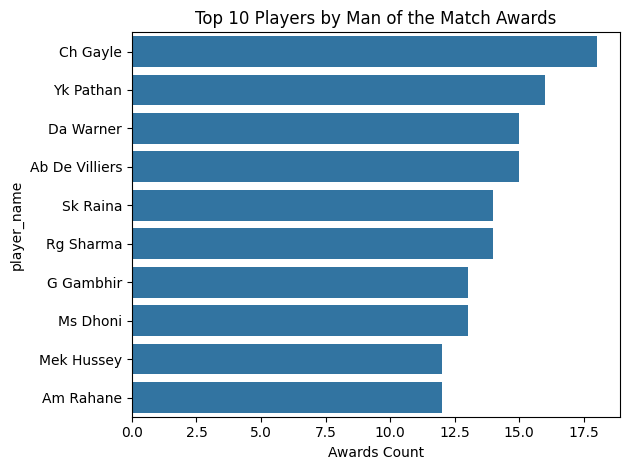

In [29]:
mom_counts = df_playermatch_pd[df_playermatch_pd['is_manofthematch'] == True]['player_name'].value_counts().head(10)
sns.barplot(y=mom_counts.index, x=mom_counts.values)
plt.title("Top 10 Players by Man of the Match Awards")
plt.xlabel("Awards Count")
plt.tight_layout()
plt.show()


In [30]:
df_team_pd = dataframes["Team"].toPandas()


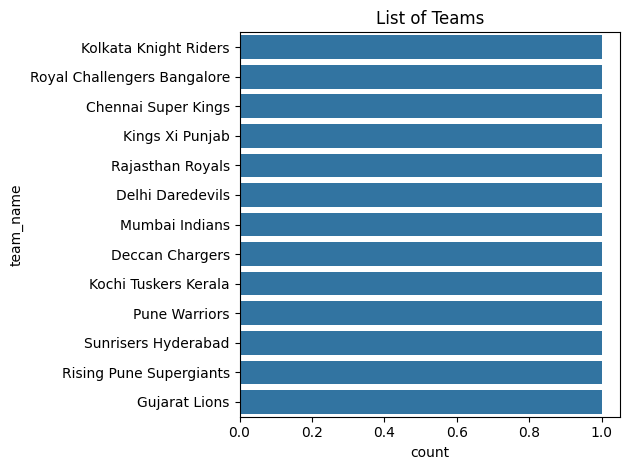

In [31]:
sns.countplot(y=df_team_pd["team_name"])
plt.title("List of Teams")
plt.tight_layout()
plt.show()


In [32]:
df_orange_cap = dataframes["Ball_By_Ball"] \
    .groupBy("striker", "season") \
    .agg(sum("runs_scored").alias("total_runs")) \
    .join(dataframes["Player"], col("striker") == col("player_id"), "left") \
    .select("player_name", "season", "total_runs") \
    .orderBy("season", "total_runs", ascending=[True, False])

df_orange_cap.show(10)


TypeError: unsupported operand type(s) for +: 'int' and 'str'

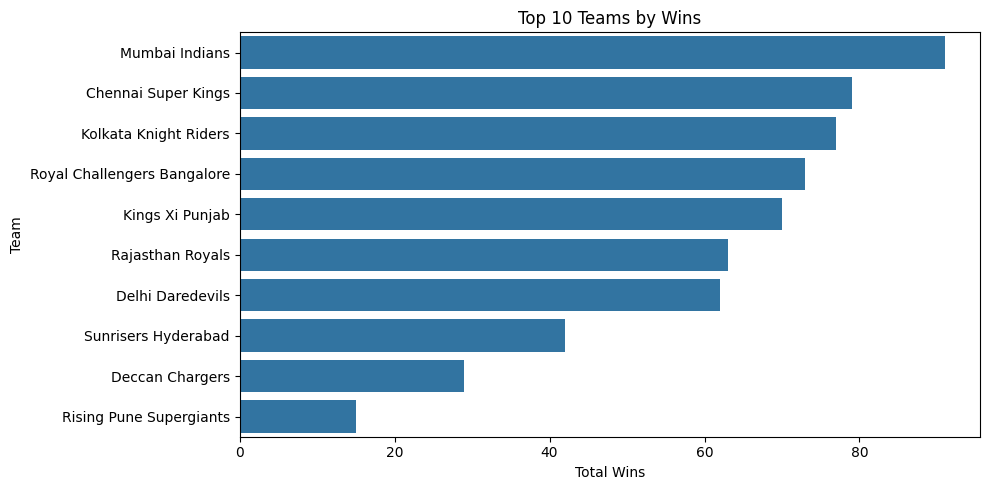

In [ ]:
df_team_wins = dataframes["Match"].groupBy("match_winner").count().orderBy(col("count").desc())
df_team_wins_pd = df_team_wins.toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_team_wins_pd.head(10), y="match_winner", x="count")
plt.title("Top 10 Teams by Wins")
plt.xlabel("Total Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


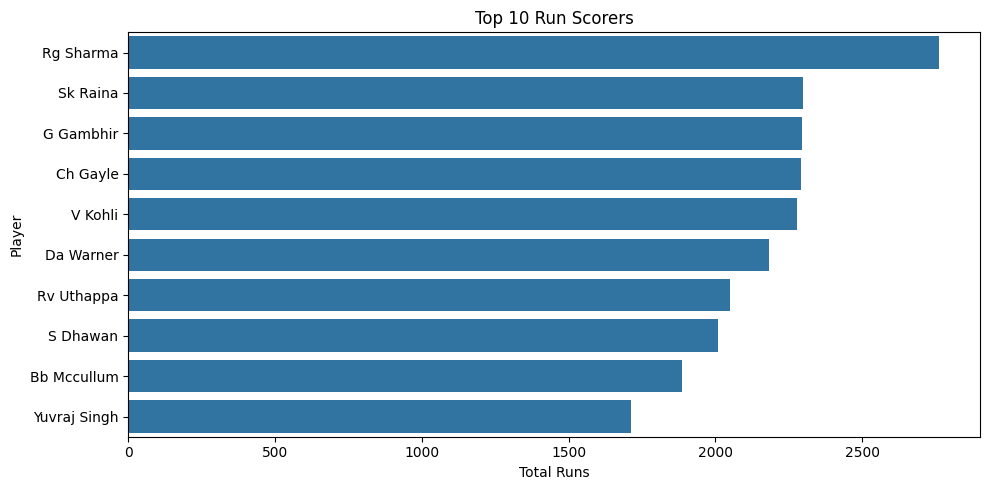

In [ ]:
df_runs = dataframes["Ball_By_Ball"].groupBy("striker") \
    .agg(sum("runs_scored").alias("total_runs")) \
    .join(dataframes["Player"], col("striker") == col("player_id"), "left") \
    .select("player_name", "total_runs").orderBy(col("total_runs").desc())

df_runs_pd = df_runs.limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_runs_pd, y="player_name", x="total_runs")
plt.title("Top 10 Run Scorers")
plt.xlabel("Total Runs")
plt.ylabel("Player")
plt.tight_layout()
plt.show()


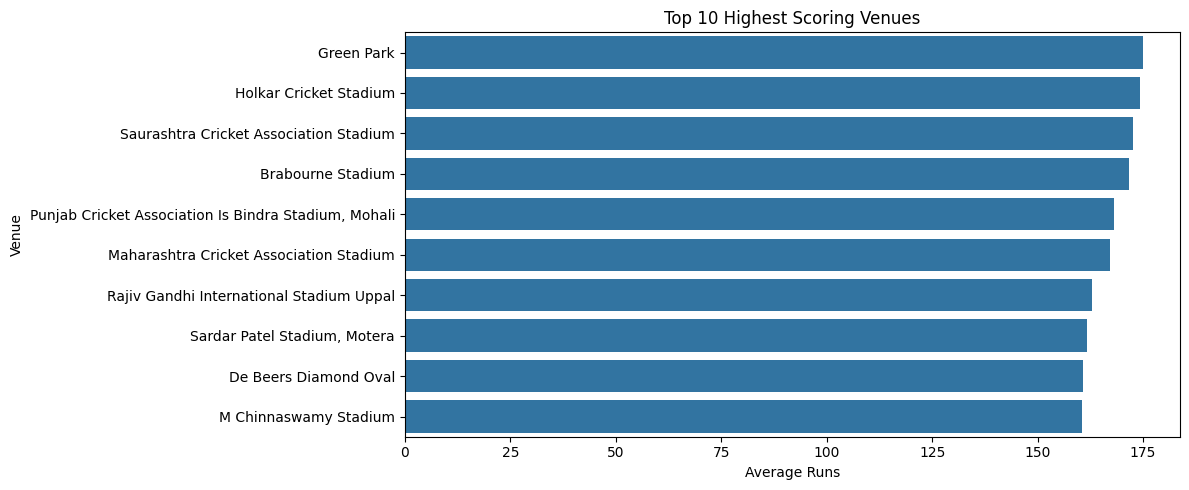

In [ ]:
df_match_runs = dataframes["Ball_By_Ball"].groupBy("match_id").agg(sum("runs_scored").alias("total_runs")) \
    .join(dataframes["Match"], "match_id", "left") \
    .groupBy("venue_name").agg(avg("total_runs").alias("avg_runs")) \
    .orderBy(col("avg_runs").desc())

df_match_runs_pd = df_match_runs.limit(10).toPandas()

plt.figure(figsize=(12, 5))
sns.barplot(data=df_match_runs_pd, y="venue_name", x="avg_runs")
plt.title("Top 10 Highest Scoring Venues")
plt.xlabel("Average Runs")
plt.ylabel("Venue")
plt.tight_layout()
plt.show()


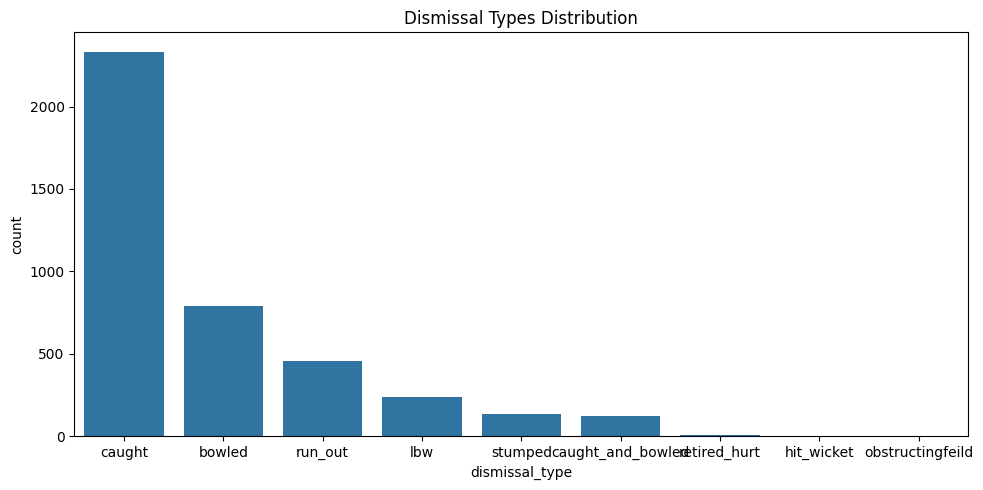

In [ ]:
df_bbb = dataframes["Ball_By_Ball"].toPandas()

dismissal_cols = ["caught", "bowled", "run_out", "lbw", "retired_hurt", "stumped", "caught_and_bowled", "hit_wicket", "obstructingfeild"]

dismissals = df_bbb[dismissal_cols].sum().sort_values(ascending=False).reset_index()
dismissals.columns = ["dismissal_type", "count"]

plt.figure(figsize=(10, 5))
sns.barplot(data=dismissals, x="dismissal_type", y="count")
plt.title("Dismissal Types Distribution")
plt.tight_layout()
plt.show()


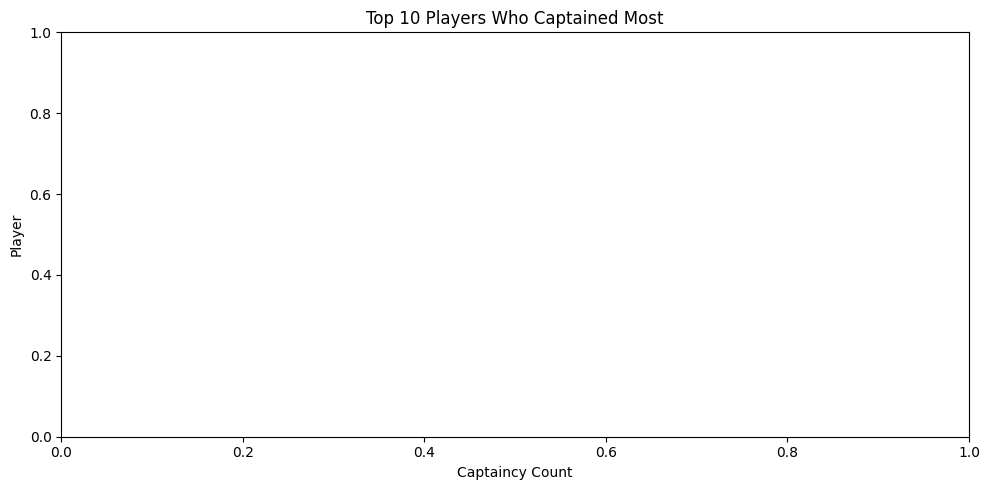

In [ ]:
df_pm = dataframes["PlayerMatch"]
df_captains = df_pm.filter(col("player_captain") == "Y").groupBy("player_name").count().orderBy(col("count").desc())

df_captains_pd = df_captains.limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=df_captains_pd, x="count", y="player_name")
plt.title("Top 10 Players Who Captained Most")
plt.xlabel("Captaincy Count")
plt.ylabel("Player")
plt.tight_layout()
plt.show()

